# CS247 Advanced Data Mining - Assignment 5
## Deadline: 11:59PM, February 28, 2023

## Instructions
Each assignment is structured as a Jupyter notebook, offering interactive tutorials that align with our lectures. You will encounter two types of problems: *write-up problems* and *coding problems*.

1. **Write-up Problems:** These problems are primarily theoretical, requiring you to demonstrate your understanding of lecture concepts and to provide mathematical proofs for key theorems. Your answers should include sufficient steps for the mathematical derivations.
2. **Coding Problems:** Here, you will be engaging with practical coding tasks. These may involve completing code segments provided in the notebooks or developing models from scratch.

To ensure clarity and consistency in your submissions, please adhere to the following guidelines:

* For write-up problems, use Markdown bullet points to format text answers. Also, express all mathematical equations using $\LaTeX$ and avoid plain text such as `x0`, `x^1`, or `R x Q` for equations.
* For coding problems, comment on your code thoroughly for readability and ensure your code is executable. Non-runnable code may lead to a loss of **all** points. Coding problems have automated grading, and altering the grading code will result in a deduction of **all** points.
* Your submission should show the entire process of data loading, preprocessing, model implementation, training, and result analysis. This can be achieved through a mix of explanatory text cells, inline comments, intermediate result displays, and experimental visualizations.

### Submission Requirements

* Submit your solutions through GradeScope in BruinLearn.
* Late submissions are allowed up to 24 hours post-deadline with a penalty factor of $\mathbf{1}(t\leq24)e^{-(\ln(2)/12)t}$.

### Collaboration and Integrity

* Collaboration is encouraged, but all final submissions must be your own work. Please acknowledge any collaboration or external sources used, including websites, papers, and GitHub repositories.
* Any suspicious cases of academic misconduct will be reported to The Office of the Dean of Students.

## Outline
* Problem 1: Network Embedding
* Problem 2: Knowledge Graph Embedding

## Problem 1: Node Embedding - LINE (40 pts = 20 + 20)


In this problem, you are going to implement the __First-order LINE__ (finish contrastive loss, negative sampling and training pipleline). Get embedding of karate graph, then visualize your results.


In [11]:
# import necessary libraries

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import trange
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sb
import networkx as nx # new dependency
import numpy as np
from scipy.linalg import sqrtm
from numpy import linalg as LA

In [12]:
# load dataset and set parameters

G = nx.karate_club_graph()
edges  = np.array(list(G.edges))
degree = dict(G.degree)
true_labels = np.zeros(len(G.nodes))
for i in range(len(true_labels)):
    if G.nodes[i]['club']=='Officer':
        true_labels[i]=1

n_epochs = 100
neg_size = 5
batchrange = 3

In [13]:
class Line(nn.Module):
    def __init__(self, size, embed_dim=128):
        super(Line, self).__init__()

        self.embed_dim = embed_dim
        self.nodes_embeddings = nn.Embedding(size, embed_dim)

        # Initialization
        self.nodes_embeddings.weight.data = self.nodes_embeddings.weight.data.uniform_(-.5, .5) / embed_dim

    def loss(self, v_i, v_j, negsamples):
        '''
        TODO:
            implement contrastive loss here
        '''

        pos_i =  self.nodes_embeddings(v_i)
        pos_j =  self.nodes_embeddings(v_j)
        neg_samples = self.nodes_embeddings(negsamples)

        # print("pos_i dim: ", pos_i.shape)
        # print("pos_j dim: ", pos_j.shape)
        # print("neg_samples dim: ", neg_samples.shape)

        # calculate the positive part of the loss function
        pos_score = torch.mul(pos_i, pos_j)
        # print("pos_score dim: ", pos_score.shape)

        pos_score = torch.sum(pos_score,dim = 1)
        pos_log = F.logsigmoid(pos_score)

        # calculate the negative sample part of the loss function
        neg_score = torch.mul(pos_i.view(len(pos_i), 1, self.embed_dim), neg_samples)
        neg_score = torch.sum(neg_score, dim=2)
        neg_log = F.logsigmoid(-1*neg_score)
        neg_log = torch.sum(neg_log, dim=1)

        loss = pos_log + neg_log

        return -torch.mean(loss)




In [14]:
# generating batches of data.

def makeData(samplededges, negsamplesize, degree):
    sampledNodes = set()
    nodesProb = []
    sumofDegree = 0
    for e in samplededges:
        sampledNodes.add(e[0])
        sampledNodes.add(e[1])
    sampledNodes = list(sampledNodes)
    nodesProb = [pow(degree[v],3/4) for v in sampledNodes]
    sumofDegree = sum(nodesProb)
    nodesProb[:] = [x/sumofDegree for x in nodesProb]

    for e in samplededges:
        sourcenode, targetnode = e[0], e[1]
        negnodes = []
        negsamples = 0
        while negsamples < negsamplesize:
            '''
            TODO:
                Randomly sampled negative nodes based on degree (d^{3/4})
            '''
            samplednode = np.random.choice(sampledNodes, p = nodesProb)
            if (samplednode == sourcenode) or (samplednode == targetnode):
                continue
            else:
                negsamples += 1
                negnodes += [samplednode]
        yield [e[0], e[1]] + negnodes




In [15]:
# training

line = Line(len(G), embed_dim=100)
opt = optim.Adam(line.parameters())
for epoch in range(n_epochs):
    for b in trange(batchrange):
        opt.zero_grad()
        edge_idx = np.random.choice(len(edges), 10)
        samplededges = edges[edge_idx]

        batch = list(makeData(samplededges, neg_size, degree))
        batch = torch.LongTensor(batch)

        # based on the generated batch, train LINE via minimizing the loss.
        v_i = batch[:,0]
        v_j = batch[:,1]
        negsamples =  batch[:,2:]
        loss = line.loss(v_i, v_j, negsamples)
        loss.backward()
        opt.step()


100%|██████████| 3/3 [00:00<00:00, 323.87it/s]


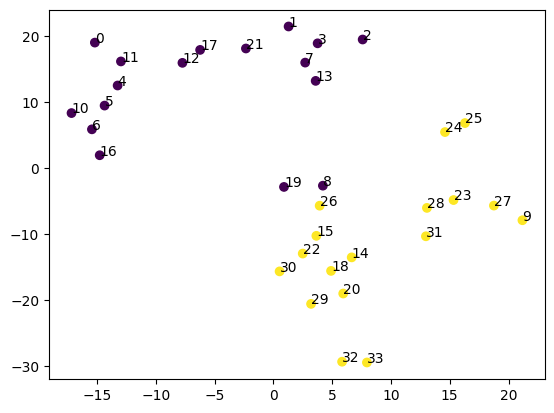

In [16]:
# TSNE visualization, with node id on

emb  = line.nodes_embeddings.weight.data.numpy()
tsne_emb = TSNE(n_components = 2, perplexity = 5, learning_rate = 10, random_state=1).fit_transform(emb)

plt.scatter(tsne_emb[:,0], tsne_emb[:,1], c=true_labels)
for i in range(len(tsne_emb)):
    plt.annotate(str(i), xy=(tsne_emb[i,0], tsne_emb[i,1]))
plt.show()



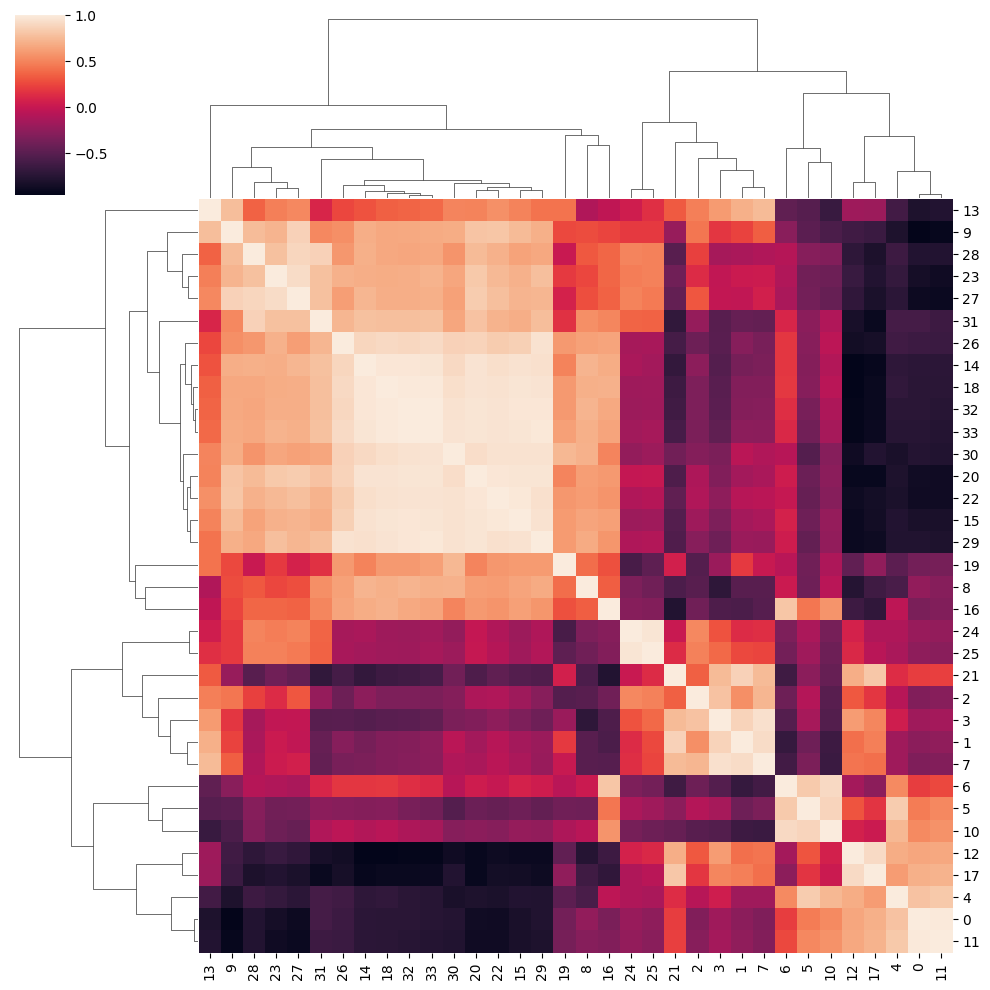

In [17]:
# heatmap visualization, check cosine similarities between all pair of nodes
res = cosine_similarity(emb)

sb.clustermap(res)
plt.show()

# Problem 2: Knowledge Graph Embedding (60 pts)

In this assignment, we implement the simple KG embedding algorithm of TransE, DistMult, and RotateE

## Part 1: Data Loading (10 pts)
This section contains the boilerplate code for data loading and dataset construction (__DO NOT MODIFY THIS PART__) unless in the TODO section

In [18]:
from torch.utils.data import Dataset, DataLoader

class TrainDataset(Dataset):
    def __init__(self, triples, nentity, nrelation, negative_sample_size, mode):
        self.len = len(triples)
        self.triples = triples
        self.triple_set = set(triples)
        self.nentity = nentity
        self.nrelation = nrelation
        self.negative_sample_size = negative_sample_size
        self.mode = mode
        self.count = self.count_frequency(triples)
        self.true_head, self.true_tail = self.get_true_head_and_tail(self.triples)

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        positive_sample = self.triples[idx]

        head, relation, tail = positive_sample

        subsampling_weight = self.count[(head, relation)] + self.count[(tail, -relation-1)]
        subsampling_weight = torch.sqrt(1 / torch.Tensor([subsampling_weight]))

        negative_sample_list = []
        negative_sample_size = 0

        while negative_sample_size < self.negative_sample_size:
            negative_sample = np.random.randint(self.nentity, size=self.negative_sample_size*2)
            if self.mode == 'head-batch':
                mask = np.in1d(
                    negative_sample,
                    self.true_head[(relation, tail)],
                    assume_unique=True,
                    invert=True
                )
            elif self.mode == 'tail-batch':
                mask = np.in1d(
                    negative_sample,
                    self.true_tail[(head, relation)],
                    assume_unique=True,
                    invert=True
                )
            else:
                raise ValueError('Training batch mode %s not supported' % self.mode)
            negative_sample = negative_sample[mask]
            negative_sample_list.append(negative_sample)
            negative_sample_size += negative_sample.size

        negative_sample = np.concatenate(negative_sample_list)[:self.negative_sample_size]

        negative_sample = torch.LongTensor(negative_sample)

        positive_sample = torch.LongTensor(positive_sample)

        return positive_sample, negative_sample, subsampling_weight, self.mode

    @staticmethod
    def collate_fn(data):
        positive_sample = torch.stack([_[0] for _ in data], dim=0)
        negative_sample = torch.stack([_[1] for _ in data], dim=0)
        subsample_weight = torch.cat([_[2] for _ in data], dim=0)
        mode = data[0][3]
        return positive_sample, negative_sample, subsample_weight, mode

    @staticmethod
    def count_frequency(triples, start=4):
        '''
        Get frequency of a partial triple like (head, relation) or (relation, tail)
        The frequency will be used for subsampling like word2vec
        '''
        count = {}
        for head, relation, tail in triples:
            if (head, relation) not in count:
                count[(head, relation)] = start
            else:
                count[(head, relation)] += 1

            if (tail, -relation-1) not in count:
                count[(tail, -relation-1)] = start
            else:
                count[(tail, -relation-1)] += 1
        return count

    @staticmethod
    def get_true_head_and_tail(triples):
        '''
        Build a dictionary of true triples that will
        be used to filter these true triples for negative sampling
        '''

        true_head = {}
        true_tail = {}

        for head, relation, tail in triples:
            if (head, relation) not in true_tail:
                true_tail[(head, relation)] = []
            true_tail[(head, relation)].append(tail)
            if (relation, tail) not in true_head:
                true_head[(relation, tail)] = []
            true_head[(relation, tail)].append(head)

        for relation, tail in true_head:
            true_head[(relation, tail)] = np.array(list(set(true_head[(relation, tail)])))
        for head, relation in true_tail:
            true_tail[(head, relation)] = np.array(list(set(true_tail[(head, relation)])))

        return true_head, true_tail


class TestDataset(Dataset):
    def __init__(self, triples, all_true_triples, nentity, nrelation, mode):
        self.len = len(triples)
        self.triple_set = set(all_true_triples)
        self.triples = triples
        self.nentity = nentity
        self.nrelation = nrelation
        self.mode = mode

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        head, relation, tail = self.triples[idx]

        if self.mode == 'head-batch':
            tmp = [(0, rand_head) if (rand_head, relation, tail) not in self.triple_set
                   else (-1, head) for rand_head in range(self.nentity)]
            tmp[head] = (0, head)
        elif self.mode == 'tail-batch':
            tmp = [(0, rand_tail) if (head, relation, rand_tail) not in self.triple_set
                   else (-1, tail) for rand_tail in range(self.nentity)]
            tmp[tail] = (0, tail)
        else:
            raise ValueError('negative batch mode %s not supported' % self.mode)

        tmp = torch.LongTensor(tmp)
        filter_bias = tmp[:, 0].float()
        negative_sample = tmp[:, 1]

        positive_sample = torch.LongTensor((head, relation, tail))

        return positive_sample, negative_sample, filter_bias, self.mode

    @staticmethod
    def collate_fn(data):
        positive_sample = torch.stack([_[0] for _ in data], dim=0)
        negative_sample = torch.stack([_[1] for _ in data], dim=0)
        filter_bias = torch.stack([_[2] for _ in data], dim=0)
        mode = data[0][3]
        return positive_sample, negative_sample, filter_bias, mode

class BidirectionalOneShotIterator(object):
    def __init__(self, dataloader_head, dataloader_tail):
        self.iterator_head = self.one_shot_iterator(dataloader_head)
        self.iterator_tail = self.one_shot_iterator(dataloader_tail)
        self.step = 0

    def __next__(self):
        self.step += 1
        if self.step % 2 == 0:
            data = next(self.iterator_head)
        else:
            data = next(self.iterator_tail)
        return data

    @staticmethod
    def one_shot_iterator(dataloader):
        while True:
            for data in dataloader:
                yield data

In [19]:
def read_triple(file_path, entity2id, relation2id):
    '''
    Read triples and map them into ids.
    '''
    triples = []
    with open(file_path) as fin:
        for line in fin:
            h, r, t = line.strip().split('\t')
            triples.append((entity2id[h], relation2id[r], entity2id[t]))
    return triples

In [20]:
import os
data_path = "wn18rr"
with open(os.path.join(data_path, 'entities.dict')) as fin:
        entity2id = dict()
        for line in fin:
            eid, entity = line.strip().split('\t')
            entity2id[entity] = int(eid)

with open(os.path.join(data_path, 'relations.dict')) as fin:
    relation2id = dict()
    for line in fin:
        rid, relation = line.strip().split('\t')
        relation2id[relation] = int(rid)

nentity = len(entity2id)
nrelation = len(relation2id)
print(f"nentity = {nentity}, nrelation={nrelation}")

nentity = 40943, nrelation=11


In [21]:
train_triples = read_triple(os.path.join(data_path, 'train.txt'), entity2id, relation2id)
valid_triples = read_triple(os.path.join(data_path, 'valid.txt'), entity2id, relation2id)
test_triples = read_triple(os.path.join(data_path, 'test.txt'), entity2id, relation2id)
print(f"n_training triples = {len(train_triples)}")
print(f"n_validation triples = {len(valid_triples)}")
print(f"n_test triples = {len(test_triples)}")

n_training triples = 86835
n_validation triples = 3034
n_test triples = 3134


In [22]:
all_true_triples = train_triples + valid_triples + test_triples

In [23]:
# TODO: create two data loaders, one for the head entities and one for the tail entities, using the DataLoader class above.

negative_sample_size = 5
batch_size = 64

train_dataset_head = TrainDataset(train_triples, nentity, nrelation, negative_sample_size, 'head-batch')
train_dataloader_head = DataLoader(train_dataset_head, batch_size=batch_size, shuffle=True, collate_fn=TrainDataset.collate_fn)

train_dataset_tail = TrainDataset(train_triples, nentity, nrelation, negative_sample_size, 'tail-batch')
train_dataloader_tail = DataLoader(train_dataset_tail, batch_size=batch_size, shuffle=True, collate_fn=TrainDataset.collate_fn)

In [24]:
train_iterator = BidirectionalOneShotIterator(train_dataloader_head, train_dataloader_tail)

## Part 2: Model Implementation (20 pts)

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [36]:
# DO NOT MODIFY THIS BLOCK
class KGEModel(nn.Module):
    def __init__(self, model_name, nentity, nrelation, hidden_dim, gamma,
                 double_entity_embedding=False, double_relation_embedding=False):
        super(KGEModel, self).__init__()
        self.model_name = model_name
        self.nentity = nentity
        self.nrelation = nrelation
        self.hidden_dim = hidden_dim
        self.epsilon = 2.0

        self.gamma = nn.Parameter(
            torch.Tensor([gamma]),
            requires_grad=False
        )

        self.embedding_range = nn.Parameter(
            torch.Tensor([(self.gamma.item() + self.epsilon) / hidden_dim]),
            requires_grad=False
        )

        self.entity_dim = hidden_dim*2 if double_entity_embedding else hidden_dim
        self.relation_dim = hidden_dim*2 if double_relation_embedding else hidden_dim

        # shallow embedding of size nentity by entity_dim
        self.entity_embedding = nn.Parameter(torch.zeros(nentity, self.entity_dim))
        nn.init.uniform_(
            tensor=self.entity_embedding,
            a=-self.embedding_range.item(),
            b=self.embedding_range.item()
        )

        self.relation_embedding = nn.Parameter(torch.zeros(nrelation, self.relation_dim))
        nn.init.uniform_(
            tensor=self.relation_embedding,
            a=-self.embedding_range.item(),
            b=self.embedding_range.item()
        )

    def forward(self, sample, mode='single'):
        '''
        Forward function that calculate the score of a batch of triples.
        In the 'single' mode, sample is a batch of triple.
        In the 'head-batch' or 'tail-batch' mode, sample consists two part.
        The first part is usually the positive sample.
        And the second part is the entities in the negative samples.
        Because negative samples and positive samples usually share two elements
        in their triple ((head, relation) or (relation, tail)).
        '''

        if mode == 'single':
            batch_size, negative_sample_size = sample.size(0), 1

            head = torch.index_select(
                self.entity_embedding,
                dim=0,
                index=sample[:,0]
            ).unsqueeze(1)

            relation = torch.index_select(
                self.relation_embedding,
                dim=0,
                index=sample[:,1]
            ).unsqueeze(1)

            tail = torch.index_select(
                self.entity_embedding,
                dim=0,
                index=sample[:,2]
            ).unsqueeze(1)

        elif mode == 'head-batch':
            tail_part, head_part = sample
            batch_size, negative_sample_size = head_part.size(0), head_part.size(1)

            head = torch.index_select(
                self.entity_embedding,
                dim=0,
                index=head_part.view(-1)
            ).view(batch_size, negative_sample_size, -1)

            relation = torch.index_select(
                self.relation_embedding,
                dim=0,
                index=tail_part[:, 1]
            ).unsqueeze(1)

            tail = torch.index_select(
                self.entity_embedding,
                dim=0,
                index=tail_part[:, 2]
            ).unsqueeze(1)

        elif mode == 'tail-batch':
            head_part, tail_part = sample
            batch_size, negative_sample_size = tail_part.size(0), tail_part.size(1)

            head = torch.index_select(
                self.entity_embedding,
                dim=0,
                index=head_part[:, 0]
            ).unsqueeze(1)

            relation = torch.index_select(
                self.relation_embedding,
                dim=0,
                index=head_part[:, 1]
            ).unsqueeze(1)

            tail = torch.index_select(
                self.entity_embedding,
                dim=0,
                index=tail_part.view(-1)
            ).view(batch_size, negative_sample_size, -1)

        else:
            raise ValueError('mode %s not supported' % mode)

        model_func = {
            'TransE': self.TransE,
            'DistMult': self.DistMult,
            'RotatE': self.RotatE,
        }

        if self.model_name in model_func:
            score = model_func[self.model_name](head, relation, tail, mode)
        else:
            raise ValueError('model %s not supported' % self.model_name)

        return score

            # rotate E
    def RotatE(self, head, relation, tail, mode):
        pi = 3.14159265358979323846

        re_head, im_head = torch.chunk(head, 2, dim=2)
        re_tail, im_tail = torch.chunk(tail, 2, dim=2)

        #Make phases of relations uniformly distributed in [-pi, pi]

        phase_relation = relation/(self.embedding_range.item()/pi)

        re_relation = torch.cos(phase_relation)
        im_relation = torch.sin(phase_relation)

        if mode == 'head-batch':
            re_score = re_relation * re_tail + im_relation * im_tail
            im_score = re_relation * im_tail - im_relation * re_tail
            re_score = re_score - re_head
            im_score = im_score - im_head
        else:
            re_score = re_head * re_relation - im_head * im_relation
            im_score = re_head * im_relation + im_head * re_relation
            re_score = re_score - re_tail
            im_score = im_score - im_tail

        score = torch.stack([re_score, im_score], dim = 0)
        score = score.norm(dim = 0)

        score = self.gamma.item() - score.sum(dim = 2)
        return score

    def TransE(self, head, relation, tail, mode):
        """
        TODO: implement the TransE score
        head, relation, tail are three embedding vectors
        mode can be head-batch or tail-batch
        """
        if mode == 'head-batch' or mode == 'single':
            score = tail + (head - relation)
        elif mode == 'tail-batch':
            score = head + (relation - tail)
        else:
            raise ValueError('mode %s not supported' % mode)

        score = -torch.norm(score, p=2, dim=2)
        return score

    def DistMult(self, head, relation, tail, mode):
        """
        TODO: implement the DistMult score
        head, relation, tail are three embedding vectors
        mode can be head-batch or tail-batch
        """
        if mode == 'head-batch' or mode == 'tail-batch' or mode == 'single':
            score = head * relation * tail
        else:
            raise ValueError('mode %s not supported' % mode)

        score = torch.sum(score, dim=2)
        return score

### TransE (10 pts)

Implement a TransE method to be used as the `model_func` in the KGModel class above:

### DistMult (10 pts)
Implement DistMult to be used by KGModel class above

## Part 3: Training, Validation, Test

In [27]:
cuda = True # if you are on colab

In [28]:
def train_step(model, optimizer, train_iterator):
        model.train()
        optimizer.zero_grad()
        positive_sample, negative_sample, _, mode = next(train_iterator)
        if cuda:
            positive_sample = positive_sample.cuda()
            negative_sample = negative_sample.cuda()
        # loss computation
        negative_score = model((positive_sample, negative_sample), mode=mode)
        negative_score = F.logsigmoid(-negative_score).mean(dim = 1)
        positive_score = model(positive_sample)
        positive_score = F.logsigmoid(positive_score).squeeze(dim = 1)
        positive_sample_loss = - positive_score.mean()
        negative_sample_loss = - negative_score.mean()
        loss = (positive_sample_loss + negative_sample_loss)/2

        loss.backward()
        optimizer.step()

        log = {
            'positive_sample_loss': positive_sample_loss.item(),
            'negative_sample_loss': negative_sample_loss.item(),
            'loss': loss.item()
        }

        return log

### Evaluation and MRR (10 pts)

The Mean Reciprocal Rank (MRR) is the usual choice to evaluate the result of knowledge graph embedding. It has the formula:
$$
MRR + \frac{1}{|Q|}\sum_{i=1}^{|Q|} \frac{1}{rank_i}
$$
where $Q$ is the set of queries, and rank is defined as the order of similarity, defined by the score in the KG embedding loss. Larger score corresponds to higher rank.

In [29]:
def test_step(model, test_triples, all_true_triples):
    model.eval()

    # TODO: create two test loaders one for head one for tail
    # set necessary hyperparameters, including batch size
    batch_size = 64

    test_dataset_head = TestDataset(test_triples, all_true_triples, nentity, nrelation, 'head-batch')
    test_dataloader_head = DataLoader(test_dataset_head, batch_size=batch_size, shuffle=False, collate_fn=TestDataset.collate_fn)

    test_dataset_tail = TestDataset(test_triples, all_true_triples, nentity, nrelation, 'tail-batch')
    test_dataloader_tail = DataLoader(test_dataset_tail, batch_size=batch_size, shuffle=False, collate_fn=TestDataset.collate_fn)


    test_dataset_list = [test_dataloader_head, test_dataloader_tail]
    logs = []
    step = 0
    test_log_steps = 10
    total_steps = sum([len(dataset) for dataset in test_dataset_list])
    with torch.no_grad():
        for test_dataset in test_dataset_list:
            for positive_sample, negative_sample, filter_bias, mode in test_dataset:
                if cuda:
                    positive_sample = positive_sample.cuda()
                    negative_sample = negative_sample.cuda()
                    filter_bias = filter_bias.cuda()

                batch_size = positive_sample.size(0)

                score = model((positive_sample, negative_sample), mode)
                score += filter_bias
                argsort = torch.argsort(score, dim = 1, descending=True)
                if mode == 'head-batch':
                    positive_arg = positive_sample[:, 0]
                elif mode == 'tail-batch':
                    positive_arg = positive_sample[:, 2]
                else:
                    raise ValueError('mode %s not supported' % mode)
                for i in range(batch_size):
                    ranking = (argsort[i, :] == positive_arg[i]).nonzero()
                    assert ranking.size(0) == 1

                    ranking = 1 + ranking.item()
                    logs.append({
                        'MRR': 1.0/ranking,
                        'MR': float(ranking),
                        'HITS@1': 1.0 if ranking <= 1 else 0.0,
                        'HITS@3': 1.0 if ranking <= 3 else 0.0,
                        'HITS@10': 1.0 if ranking <= 10 else 0.0,
                    })
                if step % test_log_steps == 0:
                    print('Evaluating the model... (%d/%d)' % (step, total_steps))

                step += 1
    metrics = {}
    for metric in logs[0].keys():
        metrics[metric] = sum([log[metric] for log in logs])/len(logs)

    return metrics

### Main Loop (20 pts)

In [30]:
# TODO: handpick hyperparameters for optimization, together with the optimizer
# then initialize 3 models, one for TransE, one for DistMult, one for RotateE
max_steps = 2000

hidden_dim = 200
gamma = 12.0
learning_rate = 0.001
negative_sample_size = 5
batch_size = 64

optimizer = optim.Adam

model_TransE = KGEModel('TransE', nentity, nrelation, hidden_dim, gamma)
model_DistMult = KGEModel('DistMult', nentity, nrelation, hidden_dim, gamma)
model_RotatE = KGEModel('RotatE', nentity, nrelation, hidden_dim, gamma)

if cuda:
    model_TransE = model_TransE.to(torch.device('cuda'))
    model_DistMult = model_DistMult.to(torch.device('cuda'))
    model_RotatE = model_RotatE.to(torch.device('cuda'))

optimizer_TransE = optimizer(model_TransE.parameters(), lr=learning_rate)
optimizer_DistMult = optimizer(model_DistMult.parameters(), lr=learning_rate)
optimizer_RotatE = optimizer(model_RotatE.parameters(), lr=learning_rate)


In [31]:
def train_model(max_steps, kge_model, optimizer):
    training_logs = []
    for step in range(0, max_steps):
        log = train_step(kge_model, optimizer, train_iterator)
        training_logs.append(log)
        if step % 200 == 0:
            metrics = test_step(kge_model, valid_triples, all_true_triples)
            print(f"step = {step}")
            print(metrics)
    return kge_model

In [32]:
# TODO: train the three models separately
train_model(max_steps=max_steps, kge_model=model_TransE, optimizer=optimizer_TransE)

Evaluating the model... (0/96)
Evaluating the model... (10/96)
Evaluating the model... (20/96)
Evaluating the model... (30/96)
Evaluating the model... (40/96)
Evaluating the model... (50/96)
Evaluating the model... (60/96)
Evaluating the model... (70/96)
Evaluating the model... (80/96)
Evaluating the model... (90/96)
step = 0
{'MRR': 0.0005552680682542164, 'MR': 20271.130191166776, 'HITS@1': 0.0003295978905735003, 'HITS@3': 0.0003295978905735003, 'HITS@10': 0.0003295978905735003}
Evaluating the model... (0/96)
Evaluating the model... (10/96)
Evaluating the model... (20/96)
Evaluating the model... (30/96)
Evaluating the model... (40/96)
Evaluating the model... (50/96)
Evaluating the model... (60/96)
Evaluating the model... (70/96)
Evaluating the model... (80/96)
Evaluating the model... (90/96)
step = 200
{'MRR': 0.013830477650519039, 'MR': 17060.089980224126, 'HITS@1': 0.006097560975609756, 'HITS@3': 0.014996704021094265, 'HITS@10': 0.02801582069874753}
Evaluating the model... (0/96)
Ev

KGEModel()

In [37]:
train_model(max_steps=max_steps, kge_model=model_DistMult, optimizer=optimizer_DistMult)

Evaluating the model... (0/96)
Evaluating the model... (10/96)
Evaluating the model... (20/96)
Evaluating the model... (30/96)
Evaluating the model... (40/96)
Evaluating the model... (50/96)
Evaluating the model... (60/96)
Evaluating the model... (70/96)
Evaluating the model... (80/96)
Evaluating the model... (90/96)
step = 0
{'MRR': 0.0003269788481312549, 'MR': 25549.70764667106, 'HITS@1': 0.0, 'HITS@3': 0.00016479894528675015, 'HITS@10': 0.0003295978905735003}
Evaluating the model... (0/96)
Evaluating the model... (10/96)
Evaluating the model... (20/96)
Evaluating the model... (30/96)
Evaluating the model... (40/96)
Evaluating the model... (50/96)
Evaluating the model... (60/96)
Evaluating the model... (70/96)
Evaluating the model... (80/96)
Evaluating the model... (90/96)
step = 200
{'MRR': 0.00029719856360884285, 'MR': 25639.946275543836, 'HITS@1': 0.0, 'HITS@3': 0.00016479894528675015, 'HITS@10': 0.00016479894528675015}
Evaluating the model... (0/96)
Evaluating the model... (10/96

KGEModel()

In [34]:
# train_model(max_steps=max_steps, kge_model=model_RotatE, optimizer=optimizer_RotatE)
# Not trained due to RuntimeError: https://piazza.com/class/lr4mq7r1gwo2qy/post/258

In [38]:
# TODO: evaluate the trained model on the test triples and report the performance

def evaluate_model(kge_model, test_dataloader):
    kge_model.eval()
    logs = []
    with torch.no_grad():
        for positive_sample, negative_sample, filter_bias, mode in test_dataloader:
            if cuda:
                positive_sample = positive_sample.cuda()
                negative_sample = negative_sample.cuda()
                filter_bias = filter_bias.cuda()
            batch_size = positive_sample.size(0)
            scores = kge_model((positive_sample, negative_sample), mode=mode)
            scores += filter_bias
            argsort = torch.argsort(scores, dim = 1, descending=True)
            if mode == 'head-batch':
                positive_arg = positive_sample[:, 0]
            elif mode == 'tail-batch':
                positive_arg = positive_sample[:, 2]
            else:
                raise ValueError('mode %s not supported' % mode)
            for i in range(batch_size):
                ranking = (argsort[i, :] == positive_arg[i]).nonzero()
                assert ranking.size(0) == 1

                ranking = 1 + ranking.item()
                logs.append({
                    'MRR': 1.0/ranking,
                    'MR': float(ranking),
                    'HITS@1': 1.0 if ranking <= 1 else 0.0,
                    'HITS@3': 1.0 if ranking <= 3 else 0.0,
                    'HITS@10': 1.0 if ranking <= 10 else 0.0,
                })

    metrics = {}
    for metric in logs[0].keys():
        metrics[metric] = sum([log[metric] for log in logs])/len(logs)
    return metrics

batch_size = 64
test_dataset_head = TestDataset(test_triples, all_true_triples, nentity, nrelation, 'head-batch')
test_dataloader_head = DataLoader(test_dataset_head, batch_size=batch_size, shuffle=False, collate_fn=TestDataset.collate_fn)
test_dataset_tail = TestDataset(test_triples, all_true_triples, nentity, nrelation, 'tail-batch')
test_dataloader_tail = DataLoader(test_dataset_tail, batch_size=batch_size, shuffle=False, collate_fn=TestDataset.collate_fn)

mrr_TransE_head = evaluate_model(model_TransE, test_dataloader_head)
mrr_TransE_tail = evaluate_model(model_TransE, test_dataloader_tail)

mrr_DistMult_head = evaluate_model(model_DistMult, test_dataloader_head)
mrr_DistMult_tail = evaluate_model(model_DistMult, test_dataloader_tail)

# mrr_RotatE_head = evaluate_model(model_RotatE, test_dataloader_head)
# mrr_RotatE_tail = evaluate_model(model_RotatE, test_dataloader_tail)

print("TransE Head MRR:", mrr_TransE_head)
print("TransE Tail MRR:", mrr_TransE_tail)

print("DistMult Head MRR:", mrr_DistMult_head)
print("DistMult Tail MRR:", mrr_DistMult_tail)

# print("RotatE Head MRR:", mrr_RotatE_head)
# print("RotatE Tail MRR:", mrr_RotatE_tail)

TransE Head MRR: {'MRR': 0.11615267358840566, 'MR': 16425.348755583916, 'HITS@1': 0.09763880025526483, 'HITS@3': 0.12827058072750477, 'HITS@10': 0.14454371410338226}
TransE Tail MRR: {'MRR': 0.00837926143434438, 'MR': 14608.220165922145, 'HITS@1': 0.0, 'HITS@3': 0.013082322910019146, 'HITS@10': 0.020740268028079132}
DistMult Head MRR: {'MRR': 0.0010080393260401958, 'MR': 22727.740587109125, 'HITS@1': 0.0, 'HITS@3': 0.0003190810465858328, 'HITS@10': 0.0012763241863433313}
DistMult Tail MRR: {'MRR': 0.000132449230715581, 'MR': 29304.474154435226, 'HITS@1': 0.0, 'HITS@3': 0.0, 'HITS@10': 0.0}
